# 实现一个猫狗识别算法
本项目实现一个识别猫狗的算法，使用深度学习构造模型。[数据集](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)使用kaggle的猫狗数据。我们将逐步剖析问题需求，从而给出解决方案。

## 参考链接
* [手把手教你如何在Kaggle猫狗大战冲到Top2%]https://ypw.io/dogs-vs-cats-2/
* [VGG论文]https://arxiv.org/pdf/1409.1556.pdf
* [ResNet论文]https://arxiv.org/pdf/1512.03385.pdf
* [Inception_V1论文]https://arxiv.org/pdf/1409.4842v1.pdf
* [Batch Normalization论文]https://arxiv.org/pdf/1502.03167.pdf
* [Inception_v2_V3论文]https://arxiv.org/pdf/1512.00567.pdf
* [Inception_V4论文]https://arxiv.org/pdf/1602.07261.pdf
* [Xception]https://arxiv.org/pdf/1610.02357.pdf
* [Starter EDA and ConvNet implementation using Keras]https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter
* [混合模型]https://www.kaggle.com/renyuanfang/pretained-models

## 加载需要的库

In [1]:
import numpy as np 
import pandas as pd
import shutil
import os, cv2, random
from keras.layers import Dense, Flatten, Dropout, Lambda, Input, concatenate
from keras.models import Model
from keras.preprocessing.image import *
from keras.applications import vgg16, resnet50, xception, inception_v3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
%matplotlib inline 
print("加载成功!")

Using TensorFlow backend.


加载成功!


## 观察并分析数据

首先我们可以先看下训练集数据的内容，下面一段代码是加载几张数据图片,我们从训练集中随机抽取了十张图片，猫狗各5张

In [3]:
dest_file_valid = 'image_data/valid/' #训练集路径
dest_file_train = 'image_data/train/' #验证集路径
test_file_path = 'image_data/test/test/' #测试集路径
save_path_postfix = 'predict.weights.best.hdf5' #保存权重后缀

In [4]:
ROWS = 256
COLS = 256
CHANNELS = 3
img_size_width = []
img_size_height = []
show_img_path = [dest_file_train + '0/cat.57.jpg', 
            dest_file_train + '0/cat.117.jpg', 
            dest_file_train + '0/cat.2.jpg', 
            dest_file_train + '0/cat.3.jpg', 
            dest_file_train + '0/cat.7.jpg', 
            dest_file_train +'1/dog.232.jpg', 
            dest_file_train + '1/dog.358.jpg', 
            dest_file_train + '1/dog.911.jpg', 
            dest_file_train + '1/dog.12499.jpg', 
            dest_file_train + '1/dog.12382.jpg']
fileNames = ['0/cat.57.jpg','cat.117.jpg','cat.2.jpg','cat.3.jpg','cat.7.jpg','dog.232.jpg',
             'dog.358.jpg','dog.911.jpg','dog.12499.jpg','dog.12382.jpg']

In [8]:
#显示图片
def show_image(file_path):
    img = cv2.imread(file_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb
    #return cv2.resize(cv_rgb, (ROWS, COLS))

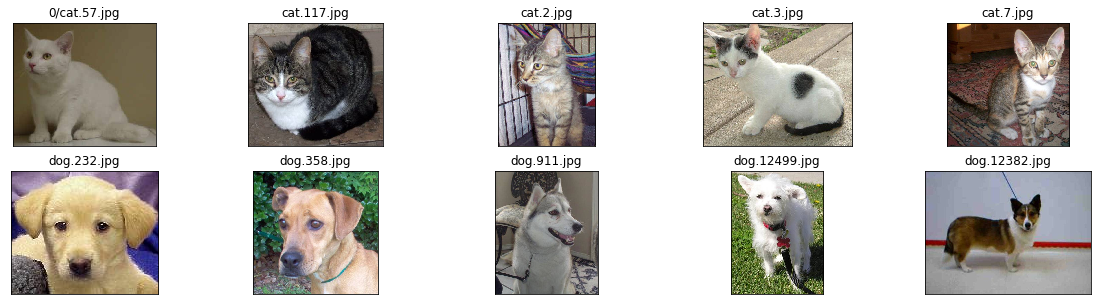

In [10]:
fig = plt.figure(figsize=(20,5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(show_image(show_img_path[i]))
    ax.set_title(fileNames[i])

我们看到图片的尺寸并不一致。例如cat57.jpg，dog.911.jpg,dog.12382.jpg，我们看下训练集数据的图片尺寸分布图。由于kaggle提供的数据中训练集数据包含25000张，我们随机抽取5000张图片看下它们的尺寸分布情况

In [30]:
fileNames = ['train/'+ imgName for imgName in os.listdir('train/')]
randam_list = random.sample(fileNames,5000)
print(len(randam_list))

5000


In [21]:
#获取图片尺寸
def get_img_size(img_path):
    img = cv2.imread(img_path)
    img_size_width.append(img.shape[1])
    img_size_height.append(img.shape[0])

#绘制散点图
def drawScatter(x,y):
    plt.scatter(x,y)
    plt.xlabel('weight')
    plt.ylabel('height')
    plt.title('image size')
    plt.show()

In [31]:
for img_path in fileNames:
    get_img_size(img_path)
print("finished!")

finished!


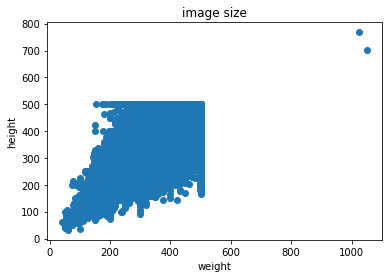

In [32]:
drawScatter(img_size_width,img_size_height)

 从图片尺寸分布散点图可以看到，图片的尺寸是有一定差异的，个别图片的尺寸明显和其它尺寸有很大不同，例如右图上那两个点。我们需要对输入图片的尺寸做一个统一尺寸处理。另外我们需要对图片做归一化处理，其实后边我选用预处理模型时候，预处理模型都会对输入图片做预处理处理，其中就包含调整图片尺寸，归一化处理等。

### 异常处理
我们再观察一下一下几张图片，我们从训练集中抽去了几张图片。

cat类别 | cat类别 | dog类别 | dog类别
- | - 
<img src="ResImage/cat.5418.jpg" width="120"> | <img src="ResImage/cat.7377.jpg" width="120"> | <img src="ResImage/dog.8736.jpg" width="120"> | <img src="ResImage/dog.6725.jpg" width="120">

显然在训练数据集中存在一些异常数据，实际类别和标签不符合的图片，或者最右边这张一堆人抱着狗的照片，这很难判断为类别是狗，
因为照片中占据主导地位的是人，针对这些情况，我们需要对数据训练数据集做一个清洗，我们试着从训练集中筛选出类似这样的异常图片，将它们从训练集中删除掉。

训练集有25000张图片，我们用眼睛观察这种人工方式是没有效率且不明智的。我们需要采用一点技巧来帮助我们。这个方法就是使用已经预训练的模型。这些模型是经过实践检验的优良模型，已经调整好权重等参数了。可以很好地帮我们完成任务。我们使用基于ImageNet数据集训练的模型，VGG，ResNet，Inception和Xception都有基于ImageNet训练的版本，我们可以从网上下载。mageNet是要对1000个物品进行分类，当然这个分类不是物种的分类，举例：狗，是物种的分类，但是具体是那种狗，ImageNet细分了118个细分类。

ImageNet分类是具体的某个动物的品种，比如如果是狗，他会给出狗的具体品种，例如拉布拉多，金毛等。所以我们需要判断出使用ImageNet数据的预训练模型给出的类别，到底是猫还是狗，或者两者什么都不是。我们需要做一个映射，用预训练的模型给出的具体的狗或者猫的品种，我们映射到仅仅是猫或者是狗就足够了。

基于IamgeNet数据集训练给出预测结果格式包含具体物种id号，具体物种名称，以及是该品种的概率。我们做了个统计，将属于猫的id号放在一起，将属于狗的id号集中到一起。看下面代码

In [100]:
dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cats=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']


通过这两个列表，我们就可以做到从拉布拉多到狗这种关系的映射了。我们选取Xception作为我们的异常图片筛选器。选取理由是Xception在ImageNet上训练效果是最佳的，官网给出的各模型评估列表如下：

<img src="ResImage/model_mc.png" width='400'>

可以看到Xception在top5的准确率最高，即给出5个可能分类，5个概率中包含正确分类的准确率。那么我们接下来的任务就是使用与训练的Xception模型对猫狗训练集做预测，将其中判断非猫非狗的图片移除掉。我们尝试判断top5，top10，top20等，其筛选的异常图片的准确率也越来越高，最后在top40中达到一个比较满意的结果。具体代码如下：

In [33]:
#判断不是狗也不是猫的图片
def findExceptionImg(img_path,topN=5):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = xception.preprocess_input(x)
    preds = model.predict(x)
    result = xception.decode_predictions(preds, top=topN)[0]
    count = 0
    for item in result:
        if (item[0] in dogs) or (item[0] in cats):
            break
        count += 1
    if count == topN:
        return True
    
    return False

In [34]:
#将非猫非狗的图片从tain文件加下剪切到exception_img/中
for img_path in fileNames:
    flag = findExceptionImg(img_path,40)
    if flag:
        shutil.move(img_path, 'exception_img/')

print("finished!")

finished!


在exception_img文件夹下有39个文件，我们将这些图片展示出来，看下我们的筛选效果如何

In [35]:
exp_img = ['exception_img/'+ imgName for imgName in os.listdir('exception_img/')]
print(len(exp_img))

39


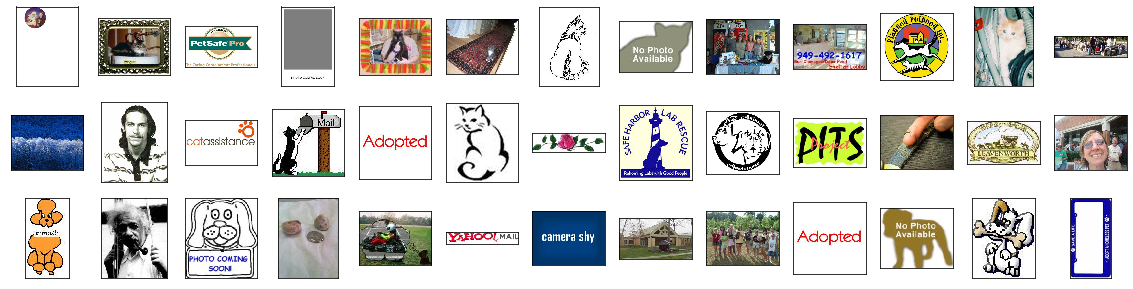

In [36]:
fig = plt.figure(figsize=(20,5))
for i in range(39):
    ax = fig.add_subplot(3, 13, i + 1, xticks=[], yticks=[])
    ax.imshow(show_image(exp_img[i]))

可以看到筛选出来的异常图片，总体还是比较令人满意，很多明显不是猫狗的杯筛选出来，还有一些图片较小，模糊不清的，人和猫狗在一起的难以判断类别的都提取出来了，基本达到了我们清洗数据的目的。

## 数据预处理

这里我们将下载的数据解压,发现数据分成tain和test两个文件夹,文件的目录结构大概是这样:


猫狗数据训练集 | 猫狗数据测试集
- | - 
<img src="ResImage/res1.png" width="120"> | <img src="ResImage/res1.png" width="120">



文件命名格式为class.id.format,例如dog.10.jpg,cat.12.jpg,并且训练集和测试集数据直接存放在train和test下，这种方式不利于我们后边使用keras的ImageDataGenerator做数据增强,因为flow_from_directory方法需要将不同种类的图片分类在不同的文件夹中,然后数据集本身还没有验证集.所以我们将train下文件夹下的数据拆分为训练集和测试集，并且我们将每个图片按照类别存放，训练集的狗放到image_data/train/1下，猫放到image_data/train/0下，同理验证集狗和猫存放分别是image_data/valid/1和image_data/valid/0

In [37]:
#从源训练数据获取文件名列表
fileNames = ['train/'+ imgName for imgName in os.listdir('train/')]

#构造类别标签,1:dog, 2:cat
labels = []
for name in fileNames:
    if 'dog' in name:
        labels.append(1)
    else:
        labels.append(0)
print(len(labels))

24961


In [38]:
#划分数据,将原始训练集划分为训练集和验证集
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(fileNames, labels, test_size=0.2, random_state=48)
print(len(X_train))
print(len(X_valid))
print(X_train[0])

19968
4993
train/dog.6488.jpg


In [49]:
train_count = 19968
valid_count = 4993
batchSize = 50
test_count = 12500

In [39]:
#将原始训练集的数据依次剪切到新的训练集和验证集路径中

for file_item in X_train:
    if 'dog' in file_item:
        shutil.move(file_item, dest_file_train + '1')
    else:
        shutil.move(file_item, dest_file_train + '0')
print("训练集完毕")        
        
for file_item in X_valid:
    if 'dog' in file_item:
        shutil.move(file_item, dest_file_valid + '1')
    else:
        shutil.move(file_item, dest_file_valid + '0')
print("验证集完毕")

训练集完毕
验证集完毕


## 迁移学习
如果我们从头开始训练一个卷积神经网络，那么需要大量的训练时间并且需要反复调整超参数，并且准确度也不会保证高于目前公开发布的模型架构，因此采用迁移学习的方式是最适合的，可以保证准确度的情况下，极大缩小训练时间.

因为我们使用预训练模型做迁移学习，需要将输入数据进行处理好匹配预处理模型需要的输入格式。我们首先要调整图片尺寸，Xception和InceptionV3需要的图片尺寸为(299,299)，并且将图片像素从(0,255)缩放到(-1,1)区间内，而VGG16和ResNet50需要的是(224,224)，并且对所有图像的所有像都减去像素均值 `[103.939, 116.779, 123.68]`(根据所有的 ImageNet 图像算出)，并将通道顺序从RGB调整为BGR。Keras中的每个模型对应的Preprocess函数帮助我们实现了这种归一化相关预处理。

In [4]:
# 如果你的环境配置了tensorflow-gpu，可以使用如下代码调用GPU进行运算，速度会快很多
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))

In [41]:
def generate_feature_model(transfer_model, input_img_size, preprocess_fun = None):
    input_img = Input(shape = (input_img_size[0], input_img_size[1], input_img_size[2]))
    x = input_img
    if preprocess_fun:
        x = Lambda(preprocess_fun)(x)
    
    base_model = transfer_model(input_tensor = x, weights = 'imagenet', include_top = False, pooling = 'avg')
        
    model = Model(input_img, base_model.output)
    model.trainable = False
    return model

In [5]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath='predict.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

### 模型超参数设置
* 采用数据增强,数据增强是从现有的训练样本中通过改变图像的显示状态来增加数据样本，丰富图像的多样化。从而使模型可以观察到更多的数据。因此使用数据增强可以提升模型的泛化能力，从而可以抑制过拟合。我们在编写代码发现适当的数据增强可以降低损失。
* 使用Adam优化器
* 使用dropout,系数为0.5
* 输出结果使用sigmoid。因为是二分类问题
* 使用二分类交叉熵对数损失函数

### 单一模型的训练结果
我们将单独使用Keras提供的VGG，ResNet和InceptionV3和Exception来训练模型，查看下哪一种模型的训练效果更好一些

In [44]:
def training_model(transfer_feature_model, input_shape,saveWeightPath='predict.weights.best.hdf5'):
    input_x = Input(shape = input_shape)
    output_y = transfer_feature_model(input_x)
    output_y = Dropout(0.5)(output_y)
    output_y = Dense(1, activation='sigmoid')(output_y)
    model = Model(input_x, output_y)
    model.compile(loss = 'binary_crossentropy',
                          optimizer = 'Adam',
                          metrics = ['accuracy'])
    
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    valid_datagen = ImageDataGenerator()
    
    train_generator = train_datagen.flow_from_directory(
                directory = 'image_data/train',
                target_size = input_shape[:2],
                shuffle = True,
                batch_size = 50, 
                class_mode='binary',
                )
    valid_generator = valid_datagen.flow_from_directory(
                directory = 'image_data/valid',
                target_size = input_shape[:2],
                shuffle = True,
                batch_size = 50, 
                class_mode='binary',
                )
    checkpointer = ModelCheckpoint(filepath=saveWeightPath, verbose=1, 
                               save_best_only=True)
    
    train_log = model.fit_generator(
    train_generator,
    epochs = 10,
    steps_per_epoch = train_count // batchSize,
    validation_data = valid_generator,
    validation_steps = valid_count // batchSize,
    verbose = 1,
    callbacks = [checkpointer,early_stopping])
    
    return train_log

In [47]:
# 训练基于VGG的单一模型
vgg16_feature = generate_feature_model(VGG16, (224, 224,3), vgg16.preprocess_input)
vgg_train_log = training_model(vgg16_feature, (224, 224,3))

Found 19968 images belonging to 2 classes.
Found 4993 images belonging to 2 classes.
Epoch 1/10
399/399 [==============================] - 614s 2s/step - loss: 0.6561 - acc: 0.8619 - val_loss: 0.1050 - val_acc: 0.9711

Epoch 00001: val_loss improved from inf to 0.10502, saving model to predict.weights.best.hdf5
Epoch 2/10
399/399 [==============================] - 602s 2s/step - loss: 0.2245 - acc: 0.9343 - val_loss: 0.0797 - val_acc: 0.9773

Epoch 00002: val_loss improved from 0.10502 to 0.07971, saving model to predict.weights.best.hdf5
Epoch 3/10
399/399 [==============================] - 611s 2s/step - loss: 0.1576 - acc: 0.9486 - val_loss: 0.0673 - val_acc: 0.9798

Epoch 00003: val_loss improved from 0.07971 to 0.06727, saving model to predict.weights.best.hdf5
Epoch 4/10
399/399 [==============================] - 594s 1s/step - loss: 0.1425 - acc: 0.9493 - val_loss: 0.0712 - val_acc: 0.9759

Epoch 00004: val_loss did not improve from 0.06727
Epoch 5/10
399/399 [==================

### 节省训练时间的方式
我们使用迁移学习训练基于VGG的自定义模型时候,我们是使用VGG卷积网络部分提取特征集。这个过程我们是使用预训练的网络模型来提取特征，所以 不涉及权重等参数的学习，因此我们可以将这个过程中提取的特征事先保存下来,将它们作为我们自己训练的模型的输入数据。这种方式只是在一开始提取特征的时候消耗一下时间,然后我们自己训练模型的时候就会很快，这样非常方便我们调试超参数训练模型，极大节省时间和效率。同理对于其它模型，使用迁移学习提取特征集这个过程，也是一样的，都可以事先保存下来。后边我们训练模型都采用这种保存特征的方式

In [7]:
#提取BottleneckFeature特征并保存
import h5py as h5
def extract_feature_save(transferModel, save_path, input_img_size, preProcess_fun, batchSize, saveLabel = False):
    input_img = Input(shape = (input_img_size[0], input_img_size[1], 3))
    #x = input_img
    if preProcess_fun:
        input_img = Lambda(preProcess_fun)(input_img)
        
    model = transferModel(input_tensor=input_img, weights='imagenet', include_top=False, pooling = 'avg')

    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    test_valid_datagen = ImageDataGenerator()
    
    train_generator = train_datagen.flow_from_directory(
                directory = 'image_data/train',
                target_size = input_img_size,
                shuffle = False,
                batch_size = batchSize, 
                class_mode='binary',
                )
    valid_generator = test_valid_datagen.flow_from_directory(
                directory = 'image_data/valid',
                target_size = input_img_size,
                shuffle = False,
                batch_size = batchSize, 
                class_mode='binary',
                )
    test_generator = test_valid_datagen.flow_from_directory(
                directory = 'image_data/test',
                target_size = input_img_size,
                shuffle = False,
                batch_size = batchSize, 
                class_mode=None,
                )
    
    train_feature = model.predict_generator(train_generator, steps=np.ceil(train_count/batchSize))
    valid_feature = model.predict_generator(valid_generator,steps=np.ceil(valid_count/batchSize))
    test_feature = model.predict_generator(test_generator,steps=np.ceil(test_count/batchSize))
    train_sample_nb = len(train_feature)
    valid_sample_nb = len(valid_feature)
    print([train_sample_nb,valid_sample_nb])
    
    with h5.File(save_path) as h:
        h.create_dataset("train", data=train_feature)
        h.create_dataset("valid", data=valid_feature)
        if saveLabel:
            h.create_dataset("train_label", data=train_generator.classes)
            h.create_dataset("valid_label", data=valid_generator.classes)
        h.create_dataset("test", data=test_feature)

In [76]:
#我们保存基于resnet,vgg,Inceptionv3,xception模型的提取的特征
extract_feature_save(ResNet50, 'resnet50.h5', (224, 224), resnet50.preprocess_input, 50, True)
extract_feature_save(VGG16, 'vgg16.h5', (224, 224), vgg16.preprocess_input, 50)
extract_feature_save(InceptionV3, 'Inceptionv3.h5', (299, 299), inception_v3.preprocess_input, 50)
extract_feature_save(Xception, 'xception.h5', (299, 299), xception.preprocess_input, 50)

print("finished")

Found 19968 images belonging to 2 classes.
Found 4993 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
[19968, 4993]
Found 19968 images belonging to 2 classes.
Found 4993 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
[19968, 4993]
Found 19968 images belonging to 2 classes.
Found 4993 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
[19968, 4993]
Found 19968 images belonging to 2 classes.
Found 4993 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
[19968, 4993]
finished


In [8]:
#读取保存的特征文件
with h5.File('resnet50.h5', 'r') as h:
    img_train_label = np.array(h['train_label'])
    img_valid_label = np.array(h['valid_label'])
    resnet_feature_train = np.array(h['train'])
    resnet_feature_valid = np.array(h['valid'])
    resnet_feature_test = np.array(h['test'])
with h5.File('vgg16.h5', 'r') as h:
    vgg_feature_train = np.array(h['train'])
    vgg_feature_valid = np.array(h['valid'])
    vgg_feature_test = np.array(h['test'])                     
with h5.File('xception.h5', 'r') as h:
    xception_feature_train = np.array(h['train'])
    xception_feature_valid = np.array(h['valid'])
    xception_feature_test = np.array(h['test'])
with h5.File('Inceptionv3.h5', 'r') as h:
    inceptionv3_feature_train = np.array(h['train'])
    inceptionv3_feature_valid = np.array(h['valid'])
    inceptionv3_feature_test = np.array(h['test'])

In [9]:
#训练模型，返回训练日志记录和模型实例
def trainByBottleneckFeature(img_train, img_train_label, img_valid, img_valid_label, saveWeightPath):
    np.random.seed(2019)
    print(img_train.shape)
    input_img = Input(img_train.shape[1:])
    x = Dropout(0.5)(input_img)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_img, x)

    model.compile(loss = 'binary_crossentropy',
                          optimizer = 'Adam',
                          metrics = ['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath=saveWeightPath, verbose=1, 
                               save_best_only=True)
    train_record = model.fit(
          img_train, img_train_label, 
          validation_data=(img_valid, img_valid_label), epochs=15, 
          batch_size=50, callbacks=[checkpointer], verbose=1)
    return model,train_record

In [79]:
#训练基于VGG的模型
model_vgg, vgg_train_log = trainByBottleneckFeature(vgg_feature_train, img_train_label, 
                                         vgg_feature_valid, img_valid_label, 'vgg_' + save_path_postfix)



(19968, 512)
Train on 19968 samples, validate on 4993 samples
Epoch 1/15
19968/19968 [==============================] - 6s 309us/step - loss: 0.5959 - acc: 0.8697 - val_loss: 0.0866 - val_acc: 0.9756

Epoch 00001: val_loss improved from inf to 0.08660, saving model to vgg_predict.weights.best.hdf5
Epoch 2/15
19968/19968 [==============================] - 3s 153us/step - loss: 0.2149 - acc: 0.9388 - val_loss: 0.1009 - val_acc: 0.9704

Epoch 00002: val_loss did not improve from 0.08660
Epoch 3/15
19968/19968 [==============================] - 3s 151us/step - loss: 0.1551 - acc: 0.9501 - val_loss: 0.0781 - val_acc: 0.9756

Epoch 00003: val_loss improved from 0.08660 to 0.07809, saving model to vgg_predict.weights.best.hdf5
Epoch 4/15
19968/19968 [==============================] - 3s 152us/step - loss: 0.1376 - acc: 0.9499 - val_loss: 0.0759 - val_acc: 0.9750

Epoch 00004: val_loss improved from 0.07809 to 0.07587, saving model to vgg_predict.weights.best.hdf5
Epoch 5/15
19968/19968 [=====

In [18]:
#训练基于inceptionv3的模型
model_inceptionv3, inceptionv3_train_log = trainByBottleneckFeature(inceptionv3_feature_train, img_train_label,
                                         inceptionv3_feature_valid, img_valid_label, 'inceptionv3_' + save_path_postfix)

(19968, 2048)
Train on 19968 samples, validate on 4993 samples
Epoch 1/15
19968/19968 [==============================] - 3s 138us/step - loss: 0.1039 - acc: 0.9662 - val_loss: 0.0301 - val_acc: 0.9936

Epoch 00001: val_loss improved from inf to 0.03007, saving model to inceptionv3_predict.weights.best.hdf5
Epoch 2/15
19968/19968 [==============================] - 3s 132us/step - loss: 0.0471 - acc: 0.9847 - val_loss: 0.0232 - val_acc: 0.9938

Epoch 00002: val_loss improved from 0.03007 to 0.02320, saving model to inceptionv3_predict.weights.best.hdf5
Epoch 3/15
19968/19968 [==============================] - 3s 128us/step - loss: 0.0419 - acc: 0.9863 - val_loss: 0.0217 - val_acc: 0.9930

Epoch 00003: val_loss improved from 0.02320 to 0.02170, saving model to inceptionv3_predict.weights.best.hdf5
Epoch 4/15
19968/19968 [==============================] - 2s 113us/step - loss: 0.0401 - acc: 0.9854 - val_loss: 0.0194 - val_acc: 0.9944

Epoch 00004: val_loss improved from 0.02170 to 0.01939,

In [81]:
#训练基于resnet的模型
model_resnet, resnet_train_log = trainByBottleneckFeature(resnet_feature_train, img_train_label,
                                         resnet_feature_valid, img_valid_label, 'resnet_' + save_path_postfix)

(19968, 2048)
Train on 19968 samples, validate on 4993 samples
Epoch 1/15
19968/19968 [==============================] - 6s 320us/step - loss: 0.1199 - acc: 0.9513 - val_loss: 0.0423 - val_acc: 0.9852

Epoch 00001: val_loss improved from inf to 0.04233, saving model to resnet_predict.weights.best.hdf5
Epoch 2/15
19968/19968 [==============================] - 3s 156us/step - loss: 0.0664 - acc: 0.9751 - val_loss: 0.0373 - val_acc: 0.9870

Epoch 00002: val_loss improved from 0.04233 to 0.03734, saving model to resnet_predict.weights.best.hdf5
Epoch 3/15
19968/19968 [==============================] - 3s 157us/step - loss: 0.0605 - acc: 0.9771 - val_loss: 0.0470 - val_acc: 0.9844

Epoch 00003: val_loss did not improve from 0.03734
Epoch 4/15
19968/19968 [==============================] - 3s 157us/step - loss: 0.0584 - acc: 0.9778 - val_loss: 0.0376 - val_acc: 0.9868

Epoch 00004: val_loss did not improve from 0.03734
Epoch 5/15
19968/19968 [==============================] - 3s 157us/step -

In [16]:
#训练基于Xception的模型
model_xception, xception_train_log = trainByBottleneckFeature(xception_feature_train, img_train_label,
                                            xception_feature_valid, img_valid_label, 'xception_' + save_path_postfix)

(19968, 2048)
Train on 19968 samples, validate on 4993 samples
Epoch 1/15
19968/19968 [==============================] - 2s 119us/step - loss: 0.1006 - acc: 0.9781 - val_loss: 0.0312 - val_acc: 0.9950

Epoch 00001: val_loss improved from inf to 0.03125, saving model to xception_predict.weights.best.hdf5
Epoch 2/15
19968/19968 [==============================] - 2s 102us/step - loss: 0.0421 - acc: 0.9865 - val_loss: 0.0264 - val_acc: 0.9942

Epoch 00002: val_loss improved from 0.03125 to 0.02644, saving model to xception_predict.weights.best.hdf5
Epoch 3/15
19968/19968 [==============================] - 2s 105us/step - loss: 0.0341 - acc: 0.9885 - val_loss: 0.0224 - val_acc: 0.9950

Epoch 00003: val_loss improved from 0.02644 to 0.02238, saving model to xception_predict.weights.best.hdf5
Epoch 4/15
19968/19968 [==============================] - 2s 103us/step - loss: 0.0327 - acc: 0.9889 - val_loss: 0.0211 - val_acc: 0.9950

Epoch 00004: val_loss improved from 0.02238 to 0.02115, saving m

### 模型评估
我们采用和kaggle上一致的二元交叉熵log损失函数来评估模型的优劣。损失函数计算如下:






$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]$$


注意下这里边我们将预测猫狗的概率做了个修正，将[0,1]的概率范围调整到[0.05.0.995],主要是kaggle使用对数损失来评估

如果概率$\hat{y}_i$是0，则对数$log(\hat{y}_i)$是无穷大，如果概率$\hat{y}_i$是1，那么$log(1 - \hat{y}_i)$是无穷大，因此我们调整概率接近[0,1],方便计算损失

In [13]:
#保存预测结果到csv文件中
def save_submit_result(predict_result, fileNames, submit_df):
    for i,file_item in enumerate(fileNames):
        index = int(file_item[:file_item.rfind('.')])
        submit_df.set_value(index-1, 'label', predict_result[i])
    submit_df.to_csv('prediction.csv', index=None)
    print("save finishd")

In [14]:
#预测并保存文件
def predictAndSave(model, img_test):
    pred_result = model.predict(img_test)
    pred_result = pred_result.clip(min=0.005, max=0.995) #概率范围调整
    test_file_path = 'image_data/test/test'
    test_filenames = os.listdir(test_file_path)
    submit_df = pd.read_csv('sample_submission.csv')
    save_submit_result(pred_result,test_filenames, submit_df)

**四个模型验证集损失对比,绘制曲线代码如下**

In [85]:
#绘制模型损失函数曲线
def visualizeLossCurve(train_log, label, log_key='val_loss', steps=15):
    plt.figure(figsize=(13,7))
    epochs = range(steps)
    for index, log_item in enumerate(train_log):
        plt.plot(epochs, log_item.history[log_key][:steps], label=label[index])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss Curvae')
    plt.legend()
    plt.show()

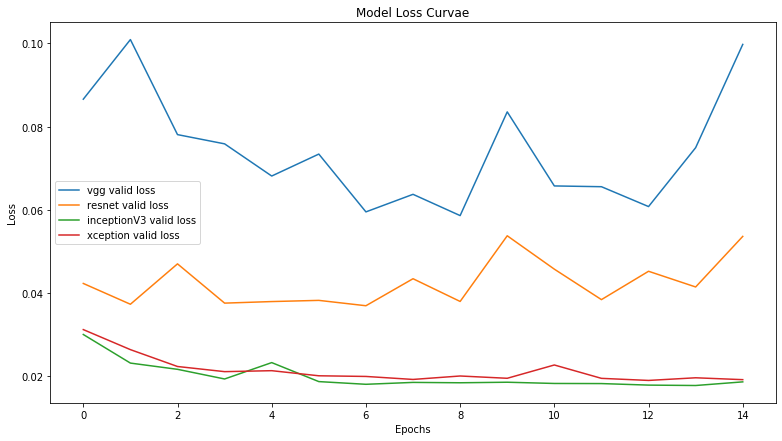

In [86]:
visualizeLossCurve([vgg_train_log,resnet_train_log,inceptionv3_train_log,xception_train_log],
                   ['vgg valid loss','resnet valid loss','inceptionV3 valid loss','xception valid loss'])

In [19]:
# 将基于迁移学习方式的模型的预测结果保存到csv文件中,并且提交到kaggle查看分数
#predictAndSave(model_vgg, vgg_feature_test)
#predictAndSave(model_resnet, resnet_feature_test)
#predictAndSave(model_xception, xception_feature_test)
predictAndSave(model_inceptionv3, inceptionv3_feature_test)

save finishd


**模型在Kaggle上的评估结果 **


vgg得分结果 | resnet得分结果
- | - 
<img src="ResImage/vgg.png"> | <img src="ResImage/resnet.png">



inceptionv3得分结果 | xception得分结果
- | - 
<img src="ResImage/inceptionv3.png"> | <img src="ResImage/xception.png">



** Kaggle排名情况 **

<img src="ResImage/record.png">

### 评估结果

我们从验证损失曲线中可以看到,基于InceptionV3和Xception的模型效果明显比基于vgg和resnet的模型好很多，在kaggle上面的得分情况也可以看到,采用vgg和resnet做迁移学习，等分情况比较落后，都无法进入10%的名次，尤其是vgg排名非常靠后。而InceptionV3和Xception得分情况则非常好，都轻松排进10%的名次,InceptionV3可以排在34名,而Xception可以排在22名,这种表现特也符合现状,这些模型是按照时间顺序一点点发展的,从vgg,resnet,inception到Xception,是一个不断改进的过程,Xception则是目前发展最优良结果,因此基于xception的迁移学习方式是比较可取的

## 改进方案

之前我们都是基于单一模型使用迁移学习，这些模型虽然也取得了不错的效果,但是由于这些网络的网络架构又有很大的差异，因此图像特征的提取也必然存在差异。于是我们想到如果将这些模组合合起来,那就是使用多个不同模型提取特征，在将这些特征合并。既然一种模型无法达到理想的效果，我们可以使用多个模型一起努力，人多力量大的原则来解决问题,这种方式增加了特征数量，有助于降低过拟合，给模型更多的信息。下面看下我们构造的模型的架构

### 模型架构


我们使用损失最小的三个模型,InceptionV3,Resnet,Xcepption进行组合，下面是我们组合模型使用的架构

<img src="ResImage/model.png" width=800 height=1200>

使用三种不用架构模型的模型，这三种模型代表了三种不同类型的特征提取方式，ResNet模型提出残差的概念来实现恒等映射，进一步控制网络因为深度太深导致的过早收敛问题。Inception系列提出的多尺寸卷积和多个小卷积核替代大卷积核思想提升了模型的训练效率，大大减少了模型的训练时间。Xception是Inception系列不断发展的极致成果，Xception在Inception基础上提出的DepthwiseSeparableConv(深度可分离卷积)，将通道和空间分开进行映射，可以进一步提升模型的性能。采用这三种模型对数据进行特征提取，并特征合并，可以起到互补的作用，并且增加了特征数量，可以让模型有了更多的参考信息，有助于模型的预测

In [20]:
#构造模型

inceptionv3_feature = generate_feature_model(InceptionV3, (299, 299, 3), inception_v3.preprocess_input)
resnet_feature = generate_feature_model(ResNet50, (224, 224, 3), resnet50.preprocess_input)
exception_feature = generate_feature_model(Xception, (299, 299, 3), xception.preprocess_input)

input_img_1 = Input(shape = (224, 224, 3))
input_img_2 = Input(shape = (299, 299, 3))
output_1 = inceptionv3_feature(input_img_1)
output_2 = resnet_feature(input_img_1)
output_3 = exception_feature(input_img_2)

merge_output = concatenate([output_1, output_2, output_3], axis=-1)                
merge_output = Dropout(0.5)(merge_output)
merge_output = Dense(1, activation='sigmoid')(merge_output)
final_model = Model([input_img_1, input_img_2], merge_output)

final_model.compile(loss = 'binary_crossentropy',
                          optimizer = 'Adam',
                          metrics = ['accuracy'])

final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 2048)         23587712    input_11[0][0]                   
__________________________________________________________________________________________________
model_7 (Model)                 (None, 2048)         21802784    input_11[0][0]                   
__________________________________________________________________________________________________
model_9 (M

### 训练组合模型
下面我们读取事先保存好的基于Resnet,inceptionv3和Xception模型提取的特征，将它们组合起来作为新的数据来训练组合模型

In [87]:
img_train = np.concatenate([resnet_feature_train,xception_feature_train,inceptionv3_feature_train], axis=-1)
img_valid = np.concatenate([resnet_feature_valid,xception_feature_valid,inceptionv3_feature_valid], axis=-1)
img_test = np.concatenate([resnet_feature_test,xception_feature_test,inceptionv3_feature_test], axis=-1)

In [88]:
np.random.seed(2019)
print(img_train.shape)
input_img = Input(img_train.shape[1:])
x = Dropout(0.5)(input_img)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_img, x)

(19968, 6144)


In [89]:
model.compile(loss = 'binary_crossentropy',
                          optimizer = 'Adam',
                          metrics = ['accuracy'])

In [90]:
train_record = model.fit(
    img_train, img_train_label, 
    validation_data=(img_valid, img_valid_label), epochs=15, 
    batch_size=50, callbacks=[checkpointer], verbose=1)

Train on 19968 samples, validate on 4993 samples
Epoch 1/15
19968/19968 [==============================] - 7s 349us/step - loss: 0.0477 - acc: 0.9832 - val_loss: 0.0167 - val_acc: 0.9950

Epoch 00001: val_loss did not improve from 0.01644
Epoch 2/15
19968/19968 [==============================] - 4s 183us/step - loss: 0.0222 - acc: 0.9921 - val_loss: 0.0201 - val_acc: 0.9934

Epoch 00002: val_loss did not improve from 0.01644
Epoch 3/15
19968/19968 [==============================] - 4s 184us/step - loss: 0.0188 - acc: 0.9938 - val_loss: 0.0207 - val_acc: 0.9938

Epoch 00003: val_loss did not improve from 0.01644
Epoch 4/15
19968/19968 [==============================] - 4s 186us/step - loss: 0.0171 - acc: 0.9940 - val_loss: 0.0222 - val_acc: 0.9938

Epoch 00004: val_loss did not improve from 0.01644
Epoch 5/15
19968/19968 [==============================] - 4s 183us/step - loss: 0.0170 - acc: 0.9937 - val_loss: 0.0231 - val_acc: 0.9938

Epoch 00005: val_loss did not improve from 0.01644
E

In [19]:
#预测并保存结果提交到Kaggle
predictAndSave(model1, img_test)


save finishd


### 评估组合模型
我们使用单一非组合的模型和组合模型做对比,之前我们比对过所有单一模型,基于Xception的迁移学习模型获得最好效果,我们就使用它和我们的组合模型做比较,看下组合模型的效果如何。

我们绘制组合模型和基于Xception的预训练模型损失曲线,并比对它们在kaggle上的排名

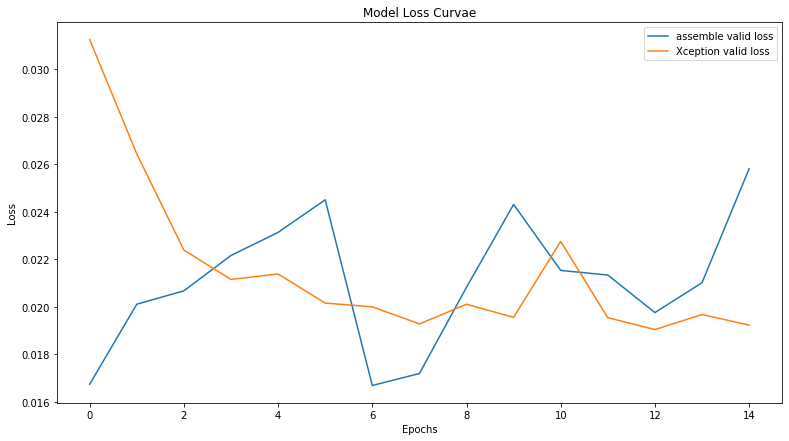

In [91]:
#15次迭代
visualizeLossCurve([train_record,xception_train_log],['assemble valid loss','Xception valid loss'])

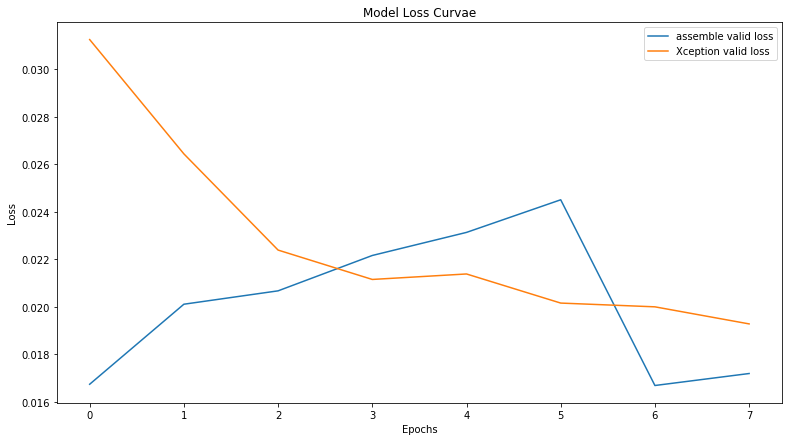

In [99]:
#前6次迭代
visualizeLossCurve([train_record,xception_train_log],['assemble valid loss','Xception valid loss'],steps=8)

模型组合得分结果 | xception得分结果
- | - 
<img src="ResImage/mixmodel.png"> | <img src="ResImage/xception.png">

** Kaggle排名情况 **

<img src="ResImage/record.png">

### 性能分析
从输出日志来看,组合模型验证损失最优值为0.0167,在第一次迭代就达到,很快就收敛到最优,而基于Xception的预训练模型最优损失在0.0193,在第7次迭代达到该最优值。组合模型的损失相对于Xception降低了13.47%,并且可以更早训练到最优解。从损失曲线图可以明显看到,组合模型在迭代次数更少的情况下达到比较理想的效果,基于Xception的预训练模型在迭代次数逐渐增加下也损失也开始越来越小,但在训练时间和损失值上都比不上组合模型,这也验证了我们的想法,可以通过将一些优秀的模型组合起来提升训练效果。

最后,我们在Kaggle上看到组合模型的得分更加优秀,排名18

### 进一步改进

我们之前使用组合模型的方式来进行特征的融合,这种方式取得了一定效果，比单一使用一种模型效果要好,但是我们也看到了模型之间架构存在差异,导致各个模型的能力大小不同,xception就强于inceptionv3,而inceptionv3也优于resnet。而我们之前那种组合特征的方式,是基于模型能力基于均衡的方式来进行特征融合的，这就导致了模型特征不平衡的问题,因为能力强的模型应该占据更好的地位，能力较弱的应该处于较低的地位。所以我们想到给不同模型设置不用的特征权重比例，性能强的模型占据高权重,反之性能弱的比重占据小一些


下面给出调整代码

In [10]:
#按照比例划分
#resnet:xception:inceptionV3  1:6:3的比例
img_train = np.concatenate([resnet_feature_train*0.1,xception_feature_train*0.6,inceptionv3_feature_train*0.3], axis=-1)
img_valid = np.concatenate([resnet_feature_valid*0.1,xception_feature_valid*0.6,inceptionv3_feature_valid*0.3], axis=-1)
img_test = np.concatenate([resnet_feature_test*0.1,xception_feature_test*0.6,inceptionv3_feature_test*0.3], axis=-1)

In [11]:
np.random.seed(2019)
print(img_train.shape)
input_img = Input(img_train.shape[1:])
x = Dropout(0.5)(input_img)
x = Dense(1, activation='sigmoid')(x)
final_model = Model(input_img, x)

final_model.compile(loss = 'binary_crossentropy',
                          optimizer = 'Adam',
                          metrics = ['accuracy'])

final_train_record = final_model.fit(
    img_train, img_train_label, 
    validation_data=(img_valid, img_valid_label), epochs=15, 
    batch_size=50, callbacks=[checkpointer], verbose=1)

(19968, 6144)
Train on 19968 samples, validate on 4993 samples
Epoch 1/15
19968/19968 [==============================] - 5s 266us/step - loss: 0.0784 - acc: 0.9860 - val_loss: 0.0227 - val_acc: 0.9952

Epoch 00001: val_loss improved from inf to 0.02269, saving model to predict.weights.best.hdf5
Epoch 2/15
19968/19968 [==============================] - 3s 134us/step - loss: 0.0264 - acc: 0.9925 - val_loss: 0.0190 - val_acc: 0.9944

Epoch 00002: val_loss improved from 0.02269 to 0.01904, saving model to predict.weights.best.hdf5
Epoch 3/15
19968/19968 [==============================] - 3s 137us/step - loss: 0.0212 - acc: 0.9931 - val_loss: 0.0178 - val_acc: 0.9946

Epoch 00003: val_loss improved from 0.01904 to 0.01783, saving model to predict.weights.best.hdf5
Epoch 4/15
19968/19968 [==============================] - 3s 133us/step - loss: 0.0186 - acc: 0.9940 - val_loss: 0.0156 - val_acc: 0.9952

Epoch 00004: val_loss improved from 0.01783 to 0.01559, saving model to predict.weights.bes

In [15]:
predictAndSave(final_model, img_test) 

save finishd


### 分析结果

我们通过设置权重比例，从日志中看到,不设置权重比例的最佳损失为0.0167，带权重比例的损失为0.01467，提升了约12.15%。我们看下两种不同设计的损失曲线，从图中可以明显看到带比例的方式要优于不带比例的方式.将结果提交到Kaggle中,看到带比例组合模型得分为0.03939，而不带比例方式的组合模型得分为0.04101，提升了大约4个百分点。从kaggle排名看,带比例的组合模型排名为15,优于不带比例的组合模型的排名18

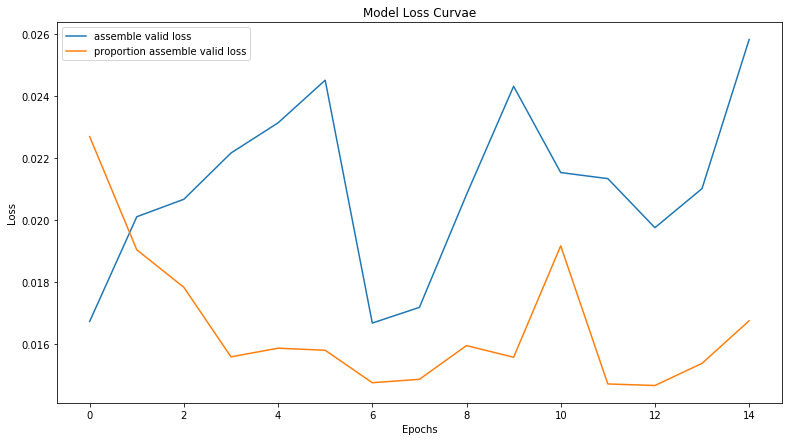

In [97]:
visualizeLossCurve([train_record,final_train_record],['assemble valid loss','proportion assemble valid loss'])

模型组合得分结果 | 带比例模型组合得分结果
- | - 
<img src="ResImage/mixmodel.png"> | <img src="ResImage/final_score.png">

** Kaggle排名情况 **

<img src="ResImage/final_record.png">

**我们预测两张图片并显示下**

In [57]:
def show_image(file_path):
    img = cv2.imread(file_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

def recognize_dogcat(predict_result):
    if predict_result > 0.5:
        print('The probability of {:.2%}  is a Dog'.format(predict_result))
    else: 
        print('The probability of {:.2%} is a Cat'.format(1-predict_result))

In [56]:
test_filenames = os.listdir(test_file_path)
pred_result = final_model.predict(img_test)
pred_result = pred_result.clip(min=0.005, max=0.995)

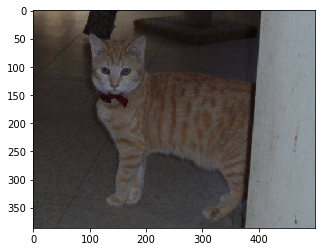

The probability of 99.50% is a Cat


In [50]:
show_image(test_file_path + test_filenames[12076])
recognize_dogcat(pred_result[12076,0])

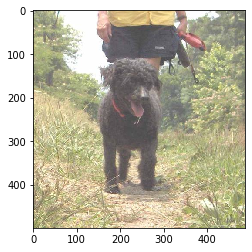

The probability of 99.50%  is a Dog


In [63]:
show_image(test_file_path + test_filenames[199])
recognize_dogcat(pred_result[199,0])

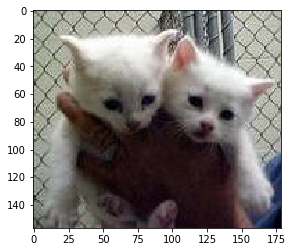

The probability of 99.15% is a Cat


In [64]:
show_image(test_file_path + test_filenames[1024])
recognize_dogcat(pred_result[1024,0])

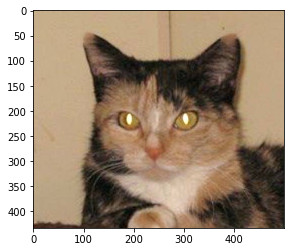

The probability of 99.50% is a Cat


In [65]:
show_image(test_file_path + test_filenames[11076])
recognize_dogcat(pred_result[11076,0])

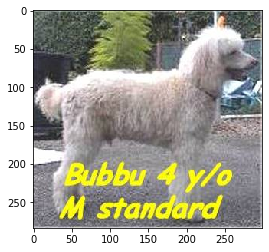

The probability of 99.50%  is a Dog


In [73]:
show_image(test_file_path + test_filenames[7000])
recognize_dogcat(pred_result[7000,0])

### 后续改进方案
如果日后有更多更全面的数据样本,可以进一步提升模型的泛化能力,抑制过拟合.或者有了更加优秀的网络架构,我们再通过组合模型的方式来提升模型性能。也可以使用更好的集成方法或者学习率递减等手段提高性能